In [467]:
import importlib
import pandas as pd
import modules.df_functions
import modules.plot_functions

# Reload user defined functions -- because notebooks keep a cached version of functions otherwise
importlib.reload(modules.df_functions)
importlib.reload(modules.plot_functions)
get_repo = modules.df_functions.get_repo
get_repo_from_source = modules.df_functions.get_repo_from_source
plot = modules.plot_functions.plot

In [468]:
path = r"C:\Users\Tom\documents\coding\cityalarms\.git"
path2 = "https://github.com/tommcdee/AI_search"
react = "https://github.com/facebook/react.git"
bluesky = "https://github.com/bluesky-social/social-app"

In [443]:
penalties = ("new typescript", 0.5)
df = get_repo(path, penalties=penalties, start=1, end=-1)

In [442]:
df2 = get_repo(path2)

In [444]:
df3 = get_repo(bluesky, group="month")

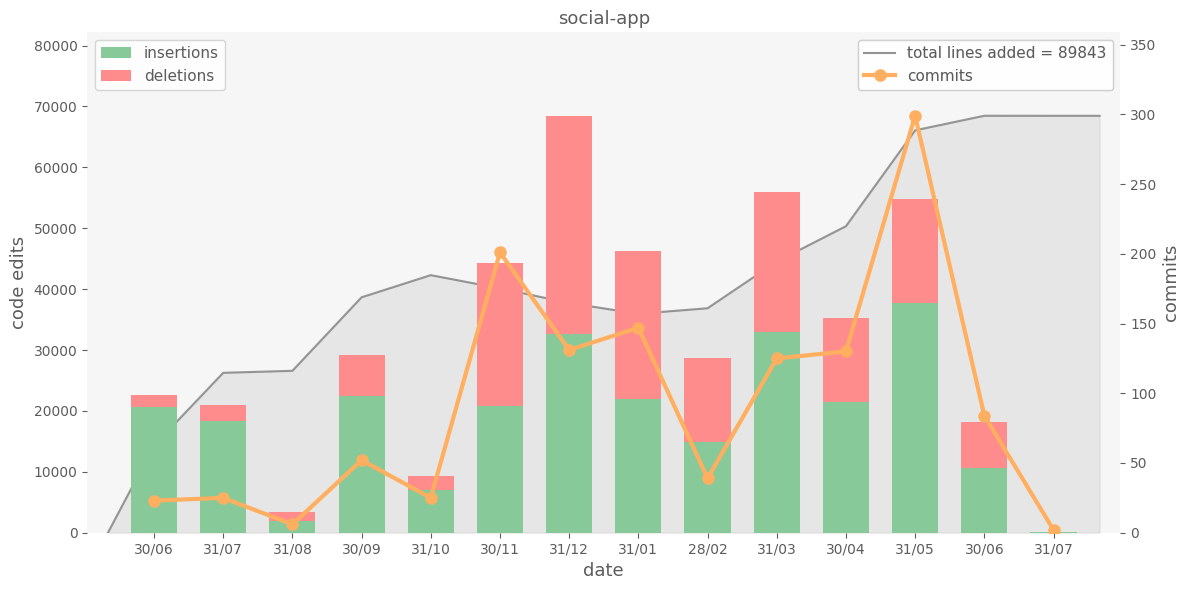

In [496]:
# Reload user defined functions -- because notebooks keep a cached version of functions otherwise
importlib.reload(modules.df_functions)
importlib.reload(modules.plot_functions)
get_repo = modules.df_functions.get_repo
get_repo_from_source = modules.df_functions.get_repo_from_source
plot = modules.plot_functions.plot
plot(df3)